<a href="https://colab.research.google.com/github/zcry332/Neural_Network/blob/main/NN_BankingProject_G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.preprocessing

dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df = pd.read_csv(dataset_url)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()
df.shape
print(f"\n Total transactions: {len(df)}")
print(f"\n Features: {df.shape[1]-1}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.describe()
print(f"Descriptive statistics\n{df.describe()}")

Descriptive statistics
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00

In [5]:
# Missing value check
num_null = df.isnull().sum().max()
# Duplicated values check
num_duplicates = df.duplicated().sum()
print(f"Number of null values: {num_null}")
print(f"Number of duplicated: {num_duplicates}")

df[df.duplicated()].head()

Number of null values: 0
Number of duplicated: 1081


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0


In [6]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

Class
0    283253
1       473
Name: count, dtype: int64


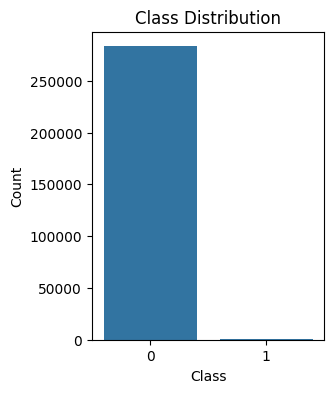

In [7]:
class_counts = df['Class'].value_counts()
print(class_counts)

# Visualize the class distribution, how many samples of each class, check the data balance.
plt.figure(figsize=(3, 4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

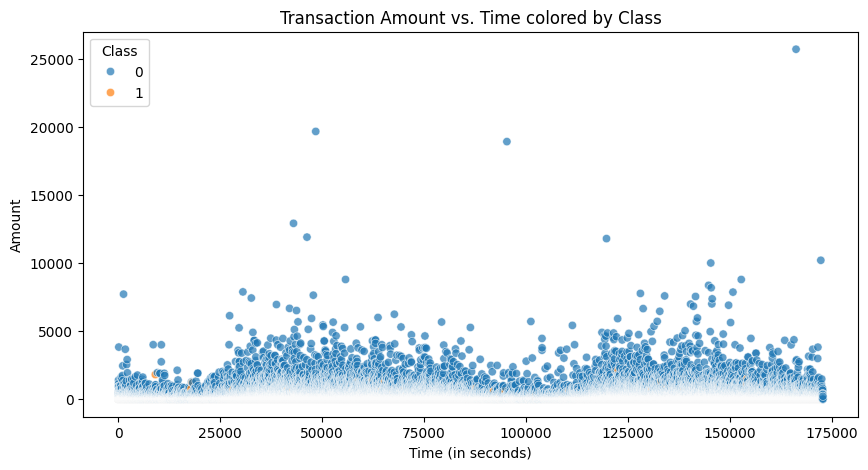

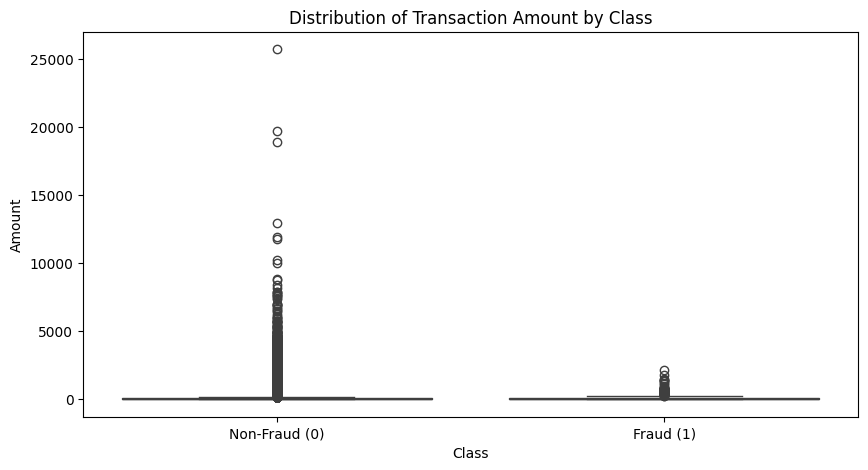

In [8]:
# spot outliers using time and amount, analyze relationship between 'Time', 'Amount', and 'Class'
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df, alpha=0.7)
plt.title('Transaction Amount vs. Time colored by Class')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

# Analyze the distribution of 'Amount' for each class, boxplot shows the relationship between class and amount.
# Superisingly the excessive amount is not fraud, and fraud values are embeding in quite small amount clustered under 3000
plt.figure(figsize=(10, 5))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribution of Transaction Amount by Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [9]:
correlation_matrixA= df.corr()

# Get correlations with the 'Class' column and sort them
class_correlations = correlation_matrixA['Class'].sort_values(ascending=False)

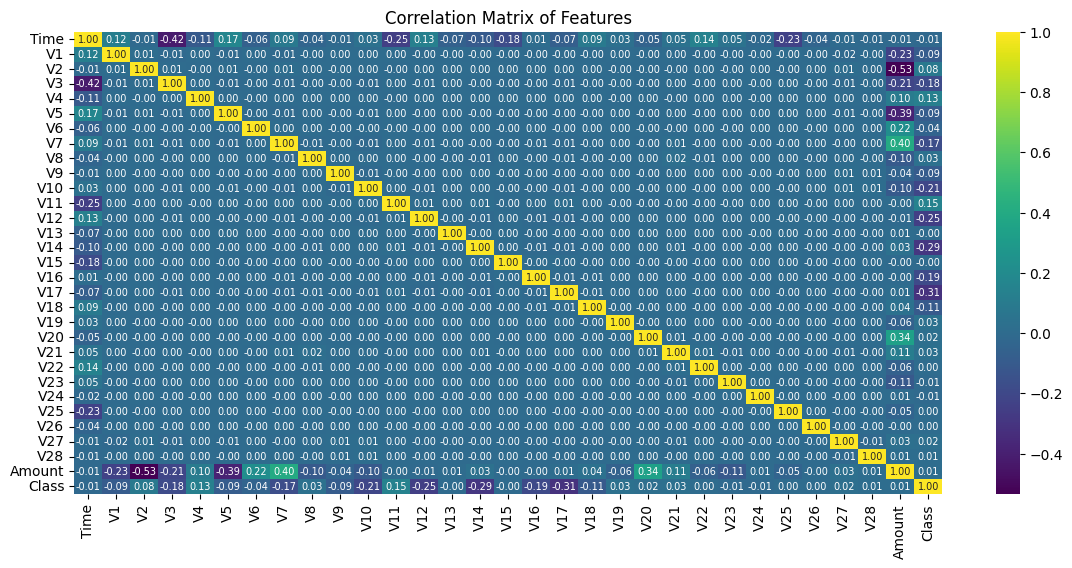

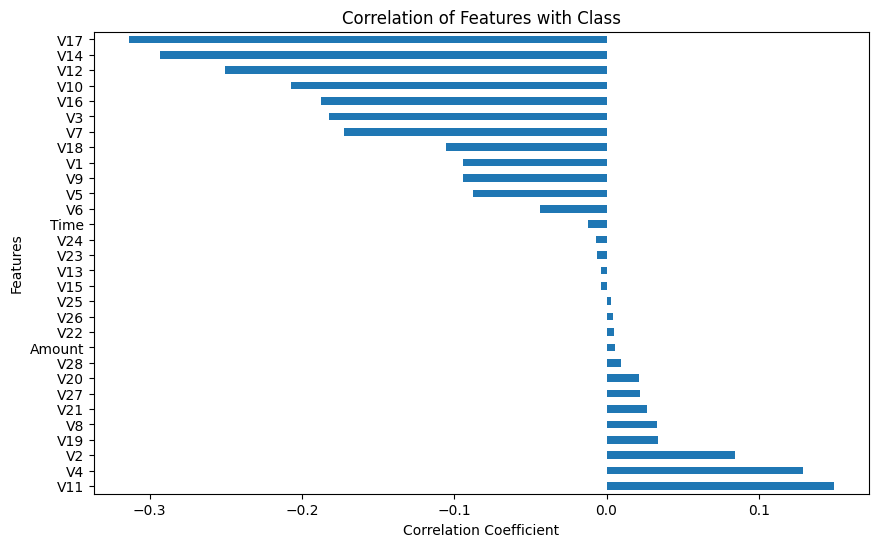

In [10]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    correlation_matrixA,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    annot_kws={'size':7}
    )
plt.title('Correlation Matrix of Features')
plt.show()

plt.figure(figsize=(10, 6))
class_correlations.drop('Class').plot(kind='barh')
plt.title('Correlation of Features with Class')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [11]:
# detect outliers using isolation forest with amount and time columns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Select features with absolute correlation greater than 0.19 with 'class', and include 'Amount' and 'Time'
selected_v_features = class_correlations[abs(class_correlations) >= 0.17].index.tolist()

df_subset = df[selected_v_features].drop(columns = ['Class'])

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_subset)

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.002, random_state=42, n_jobs=-1) # set up expected proportion of outliers in the dataset based on the actual fraud rate
predictions = iso_forest.fit_predict(df_scaled)

# Identify outliers (predicted as -1)
outliers_isoforest = df_subset[predictions == -1]

print(f"Number of outliers detected by Isolation Forest: {len(outliers_isoforest)}")
print("\nFirst 5 outliers:")
print(outliers_isoforest.head())

Number of outliers detected by Isolation Forest: 568

First 5 outliers:
            V7        V3       V16        V10        V12        V14        V17
2963 -9.198175 -2.742492  2.825793  -5.453339   2.771415   3.189651   2.126128
4895  4.163343  1.999942 -1.396627  11.936393  -3.393634  -4.632961  -2.648779
6108 -3.496197 -2.592844 -7.358083  -4.801637 -10.912819  -6.771097 -12.598419
6329  1.713445 -4.304597  2.581851  -2.447469  -4.609628  -6.079337   6.739384
6331 -1.631735 -6.240697 -2.041974  -6.187891  -9.854485 -10.691196  -1.129056


Now that the outliers have been identified, we will remove them from the dataset to improve the model's performance.

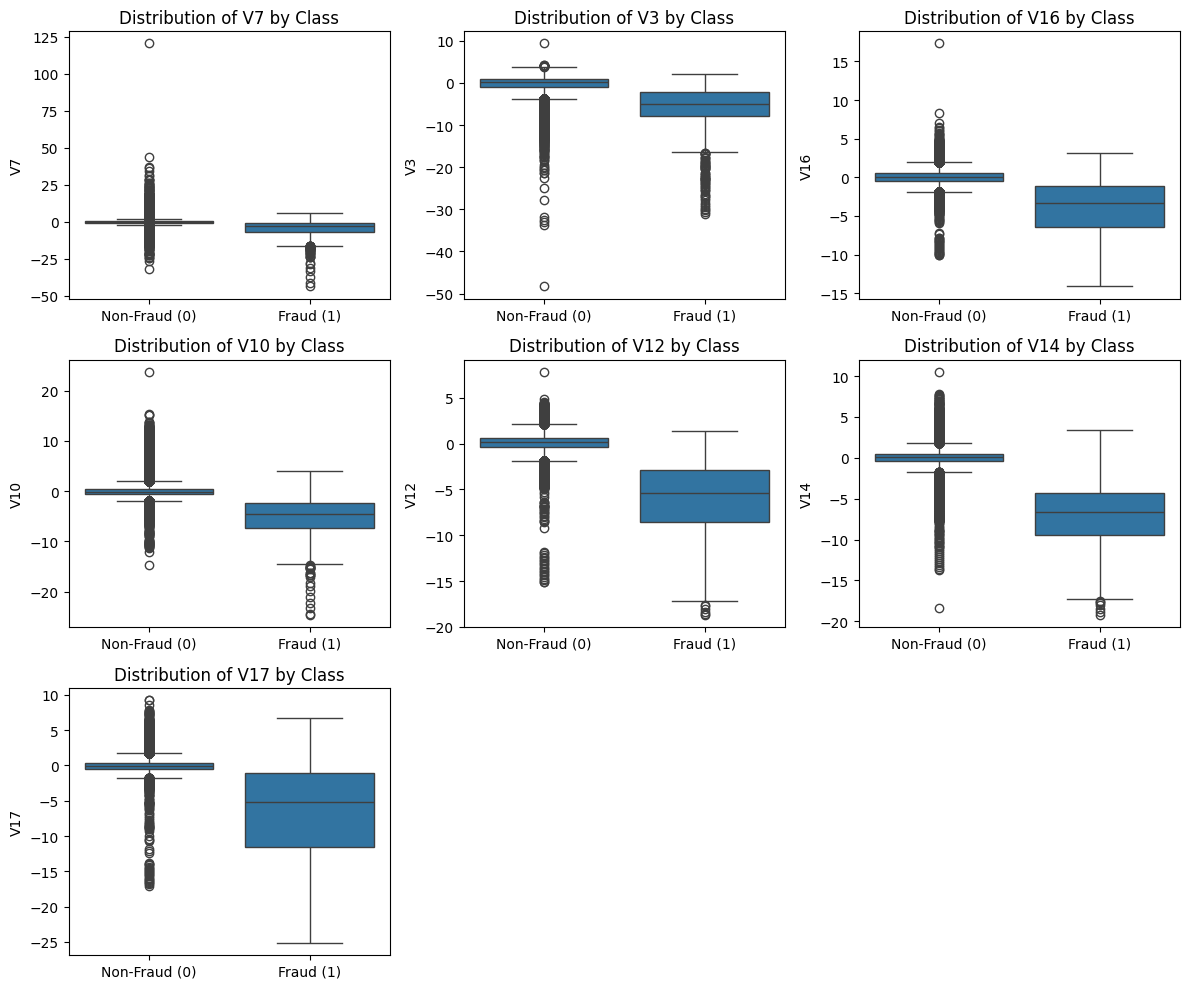

In [12]:
plt.figure(figsize=(12, 10))
for i, feature in enumerate(df_subset):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='Class', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel('')
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])

plt.tight_layout()
plt.show()


# EDA completed

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LeakyReLU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


# Separate features X and target y
y = df['Class']
X = df.drop('Class', axis=1)

print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")

# train/test split, since the output of this model is binary, use STRATIFY to prevent bias
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Shape of features (X): (283726, 30)
Shape of target (y): (283726,)


In [14]:
# Since the dataset is all numerical, therefore, there is no encoding categorical variables for training
# there is no embeding necessary for this dataset as well
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# create the model
def create_FFNN(input_dim):
   # Creates a Feedforward Neural Network model.
    model = keras.Sequential([
        layers.Dense(258, activation=LeakyReLU(alpha=0.1), input_shape=(input_dim,)),
        layers.Dense(128, activation=LeakyReLU(alpha=0.1)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid') # Changed to 1 neuron with sigmoid for binary classification
    ])
    return model

In [19]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)

{np.int64(0): np.float64(0.5008340614822464), np.int64(1): np.float64(300.23809523809524)}


In [20]:
# Instantiate the model
model = create_FFNN(X_train_scaled.shape[1])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(curve='ROC', name='auc'),
                  tf.keras.metrics.AUC(curve='PR', name='auprc'),
              ])

model.summary()

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,  # You can adjust the number of epochs
    batch_size=32, # You can adjust the batch size
    validation_split=0.2, # Using a validation split for monitoring
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]# Add class weights here
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 258)            │         7,998 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        33,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,519 (201.25 KB)

 Trainable params: 51,519 (201.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9636 - auc: 0.8971 - auprc: 0.3448 - loss: 1.1290 - precision: 0.0684 - recall: 0.8056 - val_accuracy: 0.7853 - val_auc: 0.9739 - val_auprc: 0.7710 - val_loss: 0.3911 - val_precision: 0.0076 - val_recall: 0.9615 - learning_rate: 0.0010
Epoch 2/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9270 - auc: 0.9750 - auprc: 0.4090 - loss: 0.2131 - precision: 0.0207 - recall: 0.9188 - val_accuracy: 0.9526 - val_auc: 0.9808 - val_auprc: 0.7143 - val_loss: 0.0963 - val_precision: 0.0333 - val_recall: 0.9487 - learning_rate: 0.0010
Epoch 3/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9398 - auc: 0.9689 - auprc: 0.6133 - loss: 0.2283 - precision: 0.0256 - recall: 0.9160 - val_accuracy: 0.9732 - val_auc: 0.9847 - val_auprc: 0.7638 - val_loss: 0.0972 - val_precision: 0.0568 - val_recall: 0.9359 - learning_rate: 0.0010
Epoch 4/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9702 - auc: 

In [22]:
# Save the trained model
model.save('fraud_detection_model.keras')
print("Model saved successfully!")

Model saved successfully!


In [23]:
# Evaluate the model on the test set
loss, accuracy, precision, recall, auc, auprc = model.evaluate(X_test_scaled, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test AUPRC: {auprc:.4f}")

# Generate predictions on the test set
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9845 - auc: 0.9464 - auprc: 0.7229 - loss: 0.0467 - precision: 0.0822 - recall: 0.8807
Test Loss: 0.0529
Test Accuracy: 0.9842
Test Precision: 0.0840
Test Recall: 0.8526
Test AUC: 0.9509
Test AUPRC: 0.6258
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.08      0.85      0.15        95

    accuracy                           0.98     56746
   macro avg       0.54      0.92      0.57     56746
weighted avg       1.00      0.98      0.99     56746


Confusion Matrix:
[[55768   883]
 [   14    81]]


The model has done a good job on catching all "non-fraud", however, it only has 8% of the "fraud" predictions are truly fraud, which means lots of false alrams even it caught all the frauds. So, F1 score is low.

##What to do next?
1. Adjust the decision threshold — _e.g., only predict class if probability > 0.9 to boost precision (at the cost of recall)_;
2. Use class weighting or resampling (_**SMOTE** / **undersampling**_) to balance the data;
3. Try other loss functions (**binary focal loss**);
4. Tune architecture or regularization slightly, including more hidden units, dropout between layers, or _**BatchNormalization()_** helps stablize learning, especially for the weak minority signal.